In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5712825314157840501
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2912380519
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13577074374688351432
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Transfer Learning Thesis

https://thedatafrog.com/en/articles/image-recognition-transfer-learning/

## Imports

In [2]:
# openCV to concatenate
import cv2

# for image name
import random

# define and move to dataset directory
import os
# the directory where the data is stored
directory = "C:/Users/user/Desktop/Dataset"
os.chdir(directory)

# duplicate combined image to other directory
import shutil

#for stopping code if not the right amount of images
import sys

# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#k-fold cross validation
import pandas as pd                                     #store all images and their class/label
from sklearn.model_selection import StratifiedKFold     
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split    #split the dataset to train-test
import tensorflow as tf                                 #for callbacks

#for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

## Crop Image to Reduce Background

We shall crop the image in order to reduce the background so that the egg in the image would be more focused on. The cropping procedure will not affect the size diference of the eggs from one another.

https://stackoverflow.com/questions/61927877/how-to-crop-opencv-image-from-center

In [ ]:
tadirect = directory + "/TwoAngleEggs"
#crop width and height
width = 3600
height = 3600

for x in os.listdir(tadirect):
    directory2 = ""
    directory2 = tadirect + "/" + x     #images to be cropped
    #print(directory2)
    
    curdir = os.listdir(directory2)
    
    for z in curdir:
        tempim1 = directory2 + "/" + z
        
        im1 = cv2.imread(tempim1)
        
        center = (im1.shape[0] / 2, im1.shape[1] / 2)
        #print(center)
        x = center[0] - width/2
        y = center[1] - height/2

        #print(x)
        #print(y)
        
        #slicing to perform cropping
        print("cropping " + z + " in dimensions (" + str(width) + "," + str(height) + ")")
        crop_img = im1[int(y):int(y+width), int(x):int(x+height)]
        
        #save and replace the image
        cv2.imwrite(tempim1, crop_img)
        print("crop finish " + z)

print("\nAll finished")

## Concatenate two angles of egg

two images of an egg are taken, one at its front and one at its back.

In [ ]:
#"""
tadirect = directory + "/TwoAngleEggs"

#check if there is the right amount of images (1 for each angle of egg)
for w in os.listdir(tadirect):
    directory2 = ""
    directory2 = tadirect + "/" + w
    curdir = os.listdir(directory2)

    #number of files in directory
    filecnt = len([name for name in curdir])
    
    if filecnt%2 == 1:
        print("ERROR (" + w + "): Incorrect number of images.")
        sys.exit()

for x in os.listdir(tadirect):
    directory2 = ""
    directory2 = tadirect + "/" + x                            #where the two images of two angles of egg is stored
    directory3 = directory  + "/CombinedTwoAngleEggs/" + x     #where to put the combined image of the angles
    #directory4 = directory  + "/ToBeUsed/" + x                 #where combined and data augmented of the image are stored
    #print(directory2)
    
    curdir = os.listdir(directory2)
    #print(curdir)
    
    #number of files in directory
    filecnt = len([name for name in curdir])
    
    for y in range(filecnt):
        if y%2 == 0:
            #print(directory2 + "/" + curdir[y])
            tempim1 = directory2 + "/" + curdir[y]
            im1 = cv2.imread(tempim1)
            #im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
            
            #print(directory2 + "/" + curdir[y+1])
            tempim2 = directory2 + "/" + curdir[y+1]
            im2 = cv2.imread(tempim2)
            
            # vertically concatenates images 
            # of same width 
            
            #resize for ResNet50
            width = 224
            height = 224

            dim = (width,height)
            
            im_v = cv2.vconcat([cv2.resize(im1, dim), cv2.resize(im2, dim)])
            #im_v = cv2.vconcat(im1,im2)
            
            # show the output image
            #cv2.imshow("image",im_v)
            #save image
            
            #create folder to store concatenated images if not existing
            newpath = directory3 + "2"
            if not os.path.exists(newpath):
                os.makedirs(newpath)
            """    
            newpath2 = directory4 + "3"
            if not os.path.exists(newpath2):
                os.makedirs(newpath2)
            """
            
            combine_img = newpath + "/IMG_" + str(random.randint(0,99999999)) + "_" + str(random.randint(0,999999)) + ".jpg"
            
            cv2.imwrite(combine_img,cv2.resize(im_v, dim))
            #shutil.copy2(combine_img, newpath2)bv
            
            print(curdir[y] + " and " + curdir[y+1] + " combined.")

print("All finished")
#"""
           
"""
im1 = cv2.imread("C:/Users/user/Desktop/Dataset/Balut-penoy/IMG_20210902_081744.jpg")
im2 = cv2.imread("C:/Users/user/Desktop/Dataset/Balut-penoy/IMG_20210902_081801.jpg")
#im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

width = 224
height = 224

dim = (width,height)

im_v = cv2.vconcat([cv2.resize(im1, dim), cv2.resize(im2, dim)])

cv2.imshow("wew",im_v)
cv2.waitKey()

#create a new image from the images
#cv2.imwrite('C:/Users/user/Desktop/Dataset/Balut-penoy/Lolo3.jpg', im_v)
"""

print()

## Put Dataset in a Dataframe

The directory of the images are put in a dataframe for preparation of splitting into train and test set.

In [3]:
combdirect = directory + "/CombinedTwoAngleEggs"
#fulldataset = directory + "/ToBeUsed"

#if not os.path.exists(fulldataset):
#    os.makedirs(fulldataset)

#needed for k-fold validation later on
image = []

if not os.path.exists(combdirect):
    print("Folder does not exist. Run the code above.")
    sys.exit()

for x in os.listdir(combdirect):
    combdirect2 = combdirect + "/" + x
    for y in os.listdir(combdirect2):
        if x == "Balut-penoy2":
            lbl = "0"
        elif x == "Salted egg2":
            lbl = "1"
        else:
            lbl = "2"
         
        #print(combdirect2 + "/" + y)
        
        #copy that image to the full dataset folder
        #shutil.copy2(combdirect2 + "/" + y, fulldataset)
        
        #append to image array
        image.append([combdirect2 + "/" + y,lbl])

In [4]:
df = pd.DataFrame(image,columns=['filename','label'])
df

,filename,label
0,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
1,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
2,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
3,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
4,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,0
...,...,...
295,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
296,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
297,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2
298,C:/Users/user/Desktop/Dataset/CombinedTwoAngle...,2


In [5]:
print(df['label'].unique())

['0' '1' '2']


In [6]:
print(df.isna().any())

filename    False
label       False
dtype: bool


## Split Data to train and test set

We will need to split the dataset to train and test set. Only the train set will be used for transfer learning with K-fold validation. Test set will be used for model prediction. Stratify is used in order to split the data in equal numbers under the classes specified.

In [17]:
## Split the data to train and test
X = df[['filename']]
y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Save the split sets to train and test set folders.

In [18]:
#folder to store the train and test set folders
fortraintest = directory + "/ToBeUsed"
if not os.path.exists(fortraintest):
    os.makedirs(fortraintest)

#train set folder
tr = fortraintest + "/train_set"
if not os.path.exists(tr):
    os.makedirs(tr)
else:
    #remove previous folder and create new one
    shutil.rmtree(tr)
    os.makedirs(tr)
    
#test set folder
te = fortraintest + "/test_set"
if not os.path.exists(te):
    os.makedirs(te)
else:
    #remove previous folder and create new one
    shutil.rmtree(te)
    os.makedirs(te)

#copying the images to the train set folder
for index, row in X_train.iterrows():
    trcpy = shutil.copy2(row['filename'], tr)
    X_train.loc[X_train['filename']==row['filename'],'filename']=trcpy #change to directory where image is copied
    
#copying the images to the test set folder
for index, row in X_test.iterrows():
    tecpy = shutil.copy2(row['filename'], te)
    X_test.loc[X_test['filename']==row['filename'],'filename']=tecpy #change to directory where image is copiedb

C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [19]:
df2 = pd.concat([X_train,y_train],axis=1)
df2

,filename,label
41,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,0
165,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
246,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
179,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
192,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
...,...,...
163,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
222,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2
157,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,1
203,C:/Users/user/Desktop/Dataset/ToBeUsed/train_s...,2


## K-fold validation on train set

https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

In [20]:
Y = df2[['label']]

kf = KFold(n_splits = 10, random_state = 7, shuffle = True)
                         
skf = StratifiedKFold(n_splits = 10, random_state = 7, shuffle = True)

In [21]:
print(Y['label'].value_counts())

0    80
1    80
2    80
Name: label, dtype: int64


## Data Augmentation

We will apply data augmentation of the dataset per epoch in order to increase the accuracy of the model

In [22]:
resnet50 = keras.applications.resnet50

imgdatagen = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
        horizontal_flip = True,
        vertical_flip = True,
    )

## Create Plot History

Plot history will display the training and validation accuracy, and training and validation loss in every epoch in a fold.

In [23]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train_loss','val_loss'])
    
    plt.show() 

## Train Model

train the model with K-fold Cross Validation. Parameters can be set each and every training to get the best accuracy as possible. Data generators are needed in order to do data augmentation through the use of the ImageDataGenerator stated above.

Found 216 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Fold number 1
Epoch 1/50
7/7 [==============================] - 7s 530ms/step - loss: 1.2683 - accuracy: 0.3981 - val_loss: 0.9272 - val_accuracy: 0.6250

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to C:/Users/user/Desktop/saved_models_2\model_1.h5


C:\Users\user\anaconda3\envs\tensorflow25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
7/7 [==============================] - 2s 314ms/step - loss: 0.9745 - accuracy: 0.5324 - val_loss: 0.8131 - val_accuracy: 0.5833

Epoch 00002: val_accuracy did not improve from 0.62500
Epoch 3/50
7/7 [==============================] - 2s 339ms/step - loss: 0.8644 - accuracy: 0.5880 - val_loss: 0.7404 - val_accuracy: 0.7500

Epoch 00003: val_accuracy improved from 0.62500 to 0.75000, saving model to C:/Users/user/Desktop/saved_models_2\model_1.h5
Epoch 4/50
7/7 [==============================] - 2s 319ms/step - loss: 0.7218 - accuracy: 0.6944 - val_loss: 0.6706 - val_accuracy: 0.7500

Epoch 00004: val_accuracy did not improve from 0.75000
Epoch 5/50
7/7 [==============================] - 2s 308ms/step - loss: 0.7362 - accuracy: 0.6435 - val_loss: 0.6406 - val_accuracy: 0.7917

Epoch 00005: val_accuracy improved from 0.75000 to 0.79167, saving model to C:/Users/user/Desktop/saved_models_2\model_1.h5
Epoch 6/50
7/7 [==============================] - 2s 312ms/step - loss: 0.6538

7/7 [==============================] - 2s 313ms/step - loss: 0.2688 - accuracy: 0.9120 - val_loss: 0.2998 - val_accuracy: 0.9167

Epoch 00042: val_accuracy did not improve from 0.91667
Epoch 43/50
7/7 [==============================] - 2s 313ms/step - loss: 0.2900 - accuracy: 0.9028 - val_loss: 0.3087 - val_accuracy: 0.8750

Epoch 00043: val_accuracy did not improve from 0.91667
Epoch 44/50
7/7 [==============================] - 2s 312ms/step - loss: 0.2794 - accuracy: 0.9120 - val_loss: 0.3753 - val_accuracy: 0.8333

Epoch 00044: val_accuracy did not improve from 0.91667
Epoch 45/50
7/7 [==============================] - 2s 313ms/step - loss: 0.2709 - accuracy: 0.9028 - val_loss: 0.3605 - val_accuracy: 0.8333

Epoch 00045: val_accuracy did not improve from 0.91667
Epoch 46/50
7/7 [==============================] - 2s 321ms/step - loss: 0.2948 - accuracy: 0.8843 - val_loss: 0.2842 - val_accuracy: 0.9167

Epoch 00046: val_accuracy did not improve from 0.91667
Epoch 47/50
7/7 [==========

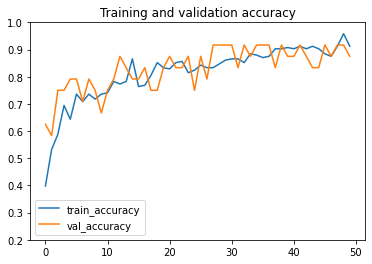

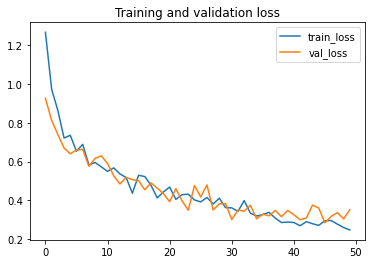

1/1 [==============================] - 0s 289ms/step - loss: 0.3269 - accuracy: 0.9167
{'loss': 0.32685521245002747, 'accuracy': 0.9166666865348816}
Found 216 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Fold number 2
Epoch 1/50
7/7 [==============================] - 6s 481ms/step - loss: 1.6412 - accuracy: 0.3056 - val_loss: 1.3394 - val_accuracy: 0.2917

Epoch 00001: val_accuracy improved from -inf to 0.29167, saving model to C:/Users/user/Desktop/saved_models_2\model_2.h5
Epoch 2/50
7/7 [==============================] - 2s 309ms/step - loss: 1.2791 - accuracy: 0.4120 - val_loss: 0.9360 - val_accuracy: 0.5417

Epoch 00002: val_accuracy improved from 0.29167 to 0.54167, saving model to C:/Users/user/Desktop/saved_models_2\model_2.h5
Epoch 3/50
7/7 [==============================] - 2s 314ms/step - loss: 1.0806 - accuracy: 0.5000 - val_loss: 0.7394 - val_accuracy: 0.7083

Epoch 00003: val_accuracy improved from 0.54167 to

7/7 [==============================] - 2s 313ms/step - loss: 0.3675 - accuracy: 0.8704 - val_loss: 0.4599 - val_accuracy: 0.8333

Epoch 00038: val_accuracy did not improve from 0.91667
Epoch 39/50
7/7 [==============================] - 2s 314ms/step - loss: 0.3597 - accuracy: 0.8843 - val_loss: 0.4259 - val_accuracy: 0.8750

Epoch 00039: val_accuracy did not improve from 0.91667
Epoch 40/50
7/7 [==============================] - 2s 313ms/step - loss: 0.3356 - accuracy: 0.9028 - val_loss: 0.4649 - val_accuracy: 0.8333

Epoch 00040: val_accuracy did not improve from 0.91667
Epoch 41/50
7/7 [==============================] - 2s 314ms/step - loss: 0.3536 - accuracy: 0.8519 - val_loss: 0.3155 - val_accuracy: 0.8750

Epoch 00041: val_accuracy did not improve from 0.91667
Epoch 42/50
7/7 [==============================] - 2s 316ms/step - loss: 0.3508 - accuracy: 0.8750 - val_loss: 0.3564 - val_accuracy: 0.8750

Epoch 00042: val_accuracy did not improve from 0.91667
Epoch 43/50
7/7 [==========

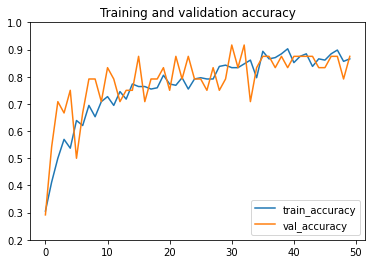

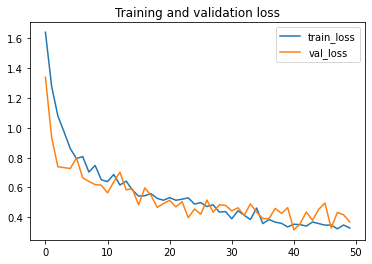

1/1 [==============================] - 0s 301ms/step - loss: 0.4580 - accuracy: 0.8750
{'loss': 0.4580070972442627, 'accuracy': 0.875}
Found 216 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Fold number 3
Epoch 1/50
7/7 [==============================] - 7s 523ms/step - loss: 1.5255 - accuracy: 0.3750 - val_loss: 0.9732 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:/Users/user/Desktop/saved_models_2\model_3.h5
Epoch 2/50
7/7 [==============================] - 2s 315ms/step - loss: 1.1338 - accuracy: 0.5417 - val_loss: 0.9287 - val_accuracy: 0.5417

Epoch 00002: val_accuracy improved from 0.50000 to 0.54167, saving model to C:/Users/user/Desktop/saved_models_2\model_3.h5
Epoch 3/50
7/7 [==============================] - 2s 308ms/step - loss: 0.9261 - accuracy: 0.5787 - val_loss: 0.8260 - val_accuracy: 0.5833

Epoch 00003: val_accuracy improved from 0.54167 to 0.58333, savi

7/7 [==============================] - 2s 312ms/step - loss: 0.3097 - accuracy: 0.8889 - val_loss: 0.5088 - val_accuracy: 0.6667

Epoch 00038: val_accuracy did not improve from 0.87500
Epoch 39/50
7/7 [==============================] - 2s 313ms/step - loss: 0.3510 - accuracy: 0.8472 - val_loss: 0.4795 - val_accuracy: 0.7500

Epoch 00039: val_accuracy did not improve from 0.87500
Epoch 40/50
7/7 [==============================] - 2s 321ms/step - loss: 0.3077 - accuracy: 0.8981 - val_loss: 0.5078 - val_accuracy: 0.7083

Epoch 00040: val_accuracy did not improve from 0.87500
Epoch 41/50
7/7 [==============================] - 2s 312ms/step - loss: 0.3332 - accuracy: 0.8611 - val_loss: 0.4830 - val_accuracy: 0.7083

Epoch 00041: val_accuracy did not improve from 0.87500
Epoch 42/50
7/7 [==============================] - 2s 319ms/step - loss: 0.2846 - accuracy: 0.8935 - val_loss: 0.4785 - val_accuracy: 0.7500

Epoch 00042: val_accuracy did not improve from 0.87500
Epoch 43/50
7/7 [==========

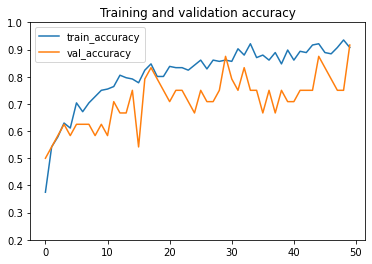

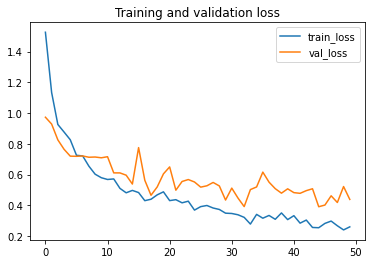

1/1 [==============================] - 0s 310ms/step - loss: 0.4856 - accuracy: 0.7917
{'loss': 0.48557719588279724, 'accuracy': 0.7916666865348816}
Found 216 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Fold number 4
Epoch 1/50
7/7 [==============================] - 7s 522ms/step - loss: 1.6386 - accuracy: 0.3796 - val_loss: 0.9163 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:/Users/user/Desktop/saved_models_2\model_4.h5
Epoch 2/50
7/7 [==============================] - 2s 311ms/step - loss: 0.9639 - accuracy: 0.5463 - val_loss: 1.0147 - val_accuracy: 0.4167

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/50
7/7 [==============================] - 2s 311ms/step - loss: 0.9650 - accuracy: 0.5509 - val_loss: 1.0581 - val_accuracy: 0.4583

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/50
7/7 [==============================] - 2s 311ms/step 

7/7 [==============================] - 2s 325ms/step - loss: 0.2991 - accuracy: 0.8889 - val_loss: 0.7037 - val_accuracy: 0.7500

Epoch 00039: val_accuracy did not improve from 0.83333
Epoch 40/50
7/7 [==============================] - 2s 310ms/step - loss: 0.2974 - accuracy: 0.8981 - val_loss: 0.6866 - val_accuracy: 0.7500

Epoch 00040: val_accuracy did not improve from 0.83333
Epoch 41/50
7/7 [==============================] - 2s 311ms/step - loss: 0.3074 - accuracy: 0.8750 - val_loss: 0.6629 - val_accuracy: 0.6250

Epoch 00041: val_accuracy did not improve from 0.83333
Epoch 42/50
7/7 [==============================] - 2s 311ms/step - loss: 0.3115 - accuracy: 0.8981 - val_loss: 0.5499 - val_accuracy: 0.7500

Epoch 00042: val_accuracy did not improve from 0.83333
Epoch 43/50
7/7 [==============================] - 2s 312ms/step - loss: 0.2476 - accuracy: 0.9306 - val_loss: 0.6714 - val_accuracy: 0.6667

Epoch 00043: val_accuracy did not improve from 0.83333
Epoch 44/50
7/7 [==========

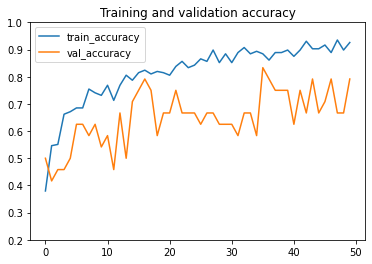

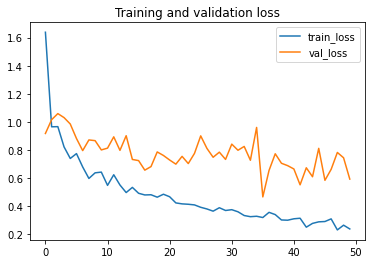

1/1 [==============================] - 0s 304ms/step - loss: 0.6675 - accuracy: 0.7500
{'loss': 0.6675159931182861, 'accuracy': 0.75}
Found 216 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Fold number 5
Epoch 1/50
7/7 [==============================] - 7s 521ms/step - loss: 1.2301 - accuracy: 0.4028 - val_loss: 0.9912 - val_accuracy: 0.4167

Epoch 00001: val_accuracy improved from -inf to 0.41667, saving model to C:/Users/user/Desktop/saved_models_2\model_5.h5
Epoch 2/50
7/7 [==============================] - 2s 313ms/step - loss: 0.9543 - accuracy: 0.5417 - val_loss: 0.7609 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.41667 to 0.50000, saving model to C:/Users/user/Desktop/saved_models_2\model_5.h5
Epoch 3/50
7/7 [==============================] - 2s 314ms/step - loss: 0.8134 - accuracy: 0.6389 - val_loss: 0.7860 - val_accuracy: 0.6667

Epoch 00003: val_accuracy improved from 0.50000 to 0.66667, savin


Epoch 00038: val_accuracy did not improve from 0.87500
Epoch 39/50
7/7 [==============================] - 2s 321ms/step - loss: 0.3553 - accuracy: 0.8657 - val_loss: 0.5011 - val_accuracy: 0.7917

Epoch 00039: val_accuracy did not improve from 0.87500
Epoch 40/50
7/7 [==============================] - 2s 312ms/step - loss: 0.3082 - accuracy: 0.8704 - val_loss: 0.5510 - val_accuracy: 0.7917

Epoch 00040: val_accuracy did not improve from 0.87500
Epoch 41/50
7/7 [==============================] - 2s 310ms/step - loss: 0.2757 - accuracy: 0.8843 - val_loss: 0.5483 - val_accuracy: 0.7917

Epoch 00041: val_accuracy did not improve from 0.87500
Epoch 42/50
7/7 [==============================] - 2s 310ms/step - loss: 0.3518 - accuracy: 0.8333 - val_loss: 0.5727 - val_accuracy: 0.8333

Epoch 00042: val_accuracy did not improve from 0.87500
Epoch 43/50
7/7 [==============================] - 2s 311ms/step - loss: 0.2787 - accuracy: 0.8889 - val_loss: 0.5179 - val_accuracy: 0.7917

Epoch 00043: v

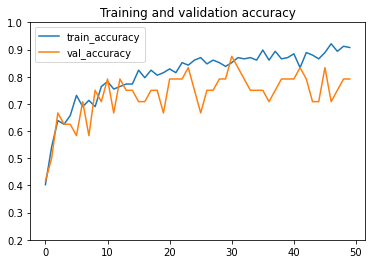

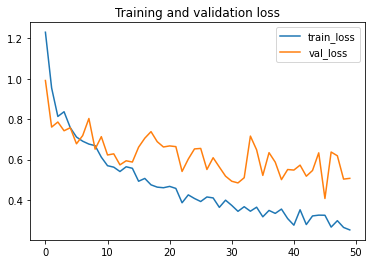

1/1 [==============================] - 0s 305ms/step - loss: 0.6324 - accuracy: 0.7917
{'loss': 0.6324232816696167, 'accuracy': 0.7916666865348816}
Found 216 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Fold number 6
Epoch 1/50
7/7 [==============================] - 8s 528ms/step - loss: 1.1840 - accuracy: 0.4444 - val_loss: 0.9571 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:/Users/user/Desktop/saved_models_2\model_6.h5
Epoch 2/50
7/7 [==============================] - 2s 322ms/step - loss: 1.0758 - accuracy: 0.4769 - val_loss: 0.7286 - val_accuracy: 0.8750

Epoch 00002: val_accuracy improved from 0.50000 to 0.87500, saving model to C:/Users/user/Desktop/saved_models_2\model_6.h5
Epoch 3/50
7/7 [==============================] - 2s 307ms/step - loss: 0.9297 - accuracy: 0.5417 - val_loss: 0.7995 - val_accuracy: 0.5833

Epoch 00003: val_accuracy did not improve from 0.87

7/7 [==============================] - 2s 319ms/step - loss: 0.3385 - accuracy: 0.8750 - val_loss: 0.3911 - val_accuracy: 0.8333

Epoch 00040: val_accuracy did not improve from 0.95833
Epoch 41/50
7/7 [==============================] - 2s 319ms/step - loss: 0.3146 - accuracy: 0.8843 - val_loss: 0.4002 - val_accuracy: 0.7917

Epoch 00041: val_accuracy did not improve from 0.95833
Epoch 42/50
7/7 [==============================] - 2s 311ms/step - loss: 0.3363 - accuracy: 0.8889 - val_loss: 0.4046 - val_accuracy: 0.9583

Epoch 00042: val_accuracy did not improve from 0.95833
Epoch 43/50
7/7 [==============================] - 2s 311ms/step - loss: 0.3209 - accuracy: 0.8750 - val_loss: 0.3530 - val_accuracy: 0.9167

Epoch 00043: val_accuracy did not improve from 0.95833
Epoch 44/50
7/7 [==============================] - 2s 310ms/step - loss: 0.3001 - accuracy: 0.8981 - val_loss: 0.3727 - val_accuracy: 0.8750

Epoch 00044: val_accuracy did not improve from 0.95833
Epoch 45/50
7/7 [==========

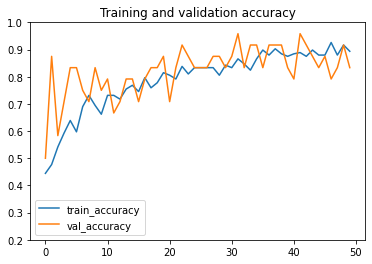

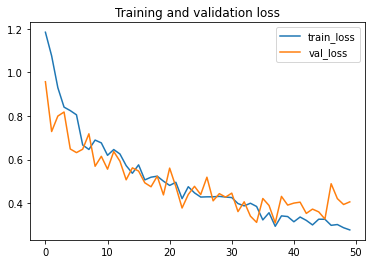

1/1 [==============================] - 0s 304ms/step - loss: 0.4922 - accuracy: 0.7917
{'loss': 0.49221479892730713, 'accuracy': 0.7916666865348816}
Found 216 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Fold number 7
Epoch 1/50
7/7 [==============================] - 7s 523ms/step - loss: 1.3312 - accuracy: 0.3889 - val_loss: 1.0196 - val_accuracy: 0.5833

Epoch 00001: val_accuracy improved from -inf to 0.58333, saving model to C:/Users/user/Desktop/saved_models_2\model_7.h5
Epoch 2/50
7/7 [==============================] - 2s 315ms/step - loss: 1.0219 - accuracy: 0.5093 - val_loss: 1.0210 - val_accuracy: 0.5833

Epoch 00002: val_accuracy did not improve from 0.58333
Epoch 3/50
7/7 [==============================] - 2s 324ms/step - loss: 0.9472 - accuracy: 0.5509 - val_loss: 0.9237 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.58333
Epoch 4/50
7/7 [==============================] - 2s 314ms/step 

7/7 [==============================] - 2s 314ms/step - loss: 0.3092 - accuracy: 0.8935 - val_loss: 0.5534 - val_accuracy: 0.7500

Epoch 00039: val_accuracy did not improve from 0.83333
Epoch 40/50
7/7 [==============================] - 2s 315ms/step - loss: 0.3461 - accuracy: 0.8889 - val_loss: 0.4750 - val_accuracy: 0.7500

Epoch 00040: val_accuracy did not improve from 0.83333
Epoch 41/50
7/7 [==============================] - 2s 314ms/step - loss: 0.2988 - accuracy: 0.9028 - val_loss: 0.4430 - val_accuracy: 0.8333

Epoch 00041: val_accuracy did not improve from 0.83333
Epoch 42/50
7/7 [==============================] - 2s 315ms/step - loss: 0.3091 - accuracy: 0.9120 - val_loss: 0.5654 - val_accuracy: 0.7500

Epoch 00042: val_accuracy did not improve from 0.83333
Epoch 43/50
7/7 [==============================] - 2s 314ms/step - loss: 0.3569 - accuracy: 0.8565 - val_loss: 0.4701 - val_accuracy: 0.7917

Epoch 00043: val_accuracy did not improve from 0.83333
Epoch 44/50
7/7 [==========

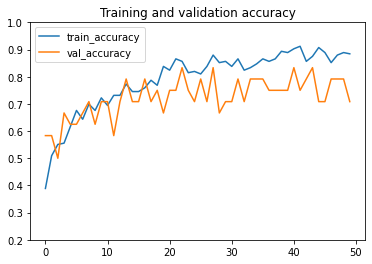

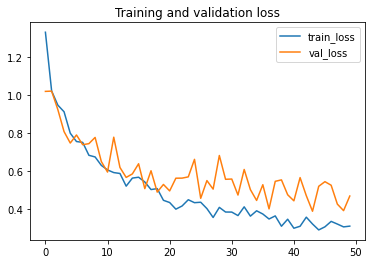

1/1 [==============================] - 0s 300ms/step - loss: 0.5675 - accuracy: 0.7500
{'loss': 0.5675401091575623, 'accuracy': 0.75}
Found 216 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Fold number 8
Epoch 1/50
7/7 [==============================] - 7s 520ms/step - loss: 1.3709 - accuracy: 0.4028 - val_loss: 1.0320 - val_accuracy: 0.3750

Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to C:/Users/user/Desktop/saved_models_2\model_8.h5
Epoch 2/50
7/7 [==============================] - 2s 313ms/step - loss: 1.0165 - accuracy: 0.5093 - val_loss: 0.8252 - val_accuracy: 0.7083

Epoch 00002: val_accuracy improved from 0.37500 to 0.70833, saving model to C:/Users/user/Desktop/saved_models_2\model_8.h5
Epoch 3/50
7/7 [==============================] - 2s 312ms/step - loss: 0.8851 - accuracy: 0.5880 - val_loss: 0.8688 - val_accuracy: 0.5833

Epoch 00003: val_accuracy did not improve from 0.70833
Epoch 4/50

7/7 [==============================] - 2s 327ms/step - loss: 0.2791 - accuracy: 0.9167 - val_loss: 0.4823 - val_accuracy: 0.7083

Epoch 00040: val_accuracy did not improve from 0.79167
Epoch 41/50
7/7 [==============================] - 2s 325ms/step - loss: 0.2663 - accuracy: 0.9259 - val_loss: 0.4712 - val_accuracy: 0.7083

Epoch 00041: val_accuracy did not improve from 0.79167
Epoch 42/50
7/7 [==============================] - 2s 311ms/step - loss: 0.2870 - accuracy: 0.9028 - val_loss: 0.4696 - val_accuracy: 0.6667

Epoch 00042: val_accuracy did not improve from 0.79167
Epoch 43/50
7/7 [==============================] - 2s 312ms/step - loss: 0.2766 - accuracy: 0.9028 - val_loss: 0.4320 - val_accuracy: 0.8333

Epoch 00043: val_accuracy improved from 0.79167 to 0.83333, saving model to C:/Users/user/Desktop/saved_models_2\model_8.h5
Epoch 44/50
7/7 [==============================] - 2s 319ms/step - loss: 0.2390 - accuracy: 0.9352 - val_loss: 0.5312 - val_accuracy: 0.6667

Epoch 00044: 

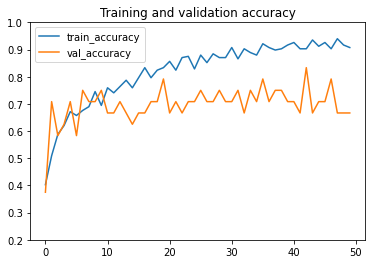

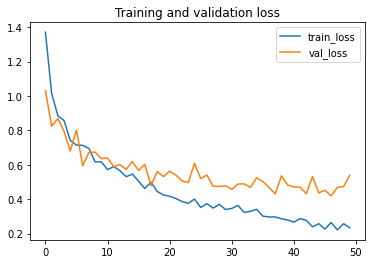

1/1 [==============================] - 0s 304ms/step - loss: 0.4681 - accuracy: 0.7500
{'loss': 0.46809637546539307, 'accuracy': 0.75}
Found 216 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Fold number 9
Epoch 1/50
7/7 [==============================] - 8s 517ms/step - loss: 1.1713 - accuracy: 0.4398 - val_loss: 0.9387 - val_accuracy: 0.4167

Epoch 00001: val_accuracy improved from -inf to 0.41667, saving model to C:/Users/user/Desktop/saved_models_2\model_9.h5
Epoch 2/50
7/7 [==============================] - 2s 313ms/step - loss: 1.0068 - accuracy: 0.5093 - val_loss: 0.7649 - val_accuracy: 0.7083

Epoch 00002: val_accuracy improved from 0.41667 to 0.70833, saving model to C:/Users/user/Desktop/saved_models_2\model_9.h5
Epoch 3/50
7/7 [==============================] - 2s 310ms/step - loss: 0.9430 - accuracy: 0.5509 - val_loss: 0.6292 - val_accuracy: 0.6667

Epoch 00003: val_accuracy did not improve from 0.70833
Epoch 4/5

7/7 [==============================] - 2s 331ms/step - loss: 0.3156 - accuracy: 0.8750 - val_loss: 0.3022 - val_accuracy: 0.8750

Epoch 00040: val_accuracy did not improve from 0.95833
Epoch 41/50
7/7 [==============================] - 2s 321ms/step - loss: 0.3401 - accuracy: 0.8611 - val_loss: 0.3327 - val_accuracy: 0.9167

Epoch 00041: val_accuracy did not improve from 0.95833
Epoch 42/50
7/7 [==============================] - 2s 317ms/step - loss: 0.3201 - accuracy: 0.8889 - val_loss: 0.2925 - val_accuracy: 0.8750

Epoch 00042: val_accuracy did not improve from 0.95833
Epoch 43/50
7/7 [==============================] - 2s 309ms/step - loss: 0.2755 - accuracy: 0.8981 - val_loss: 0.2659 - val_accuracy: 0.9167

Epoch 00043: val_accuracy did not improve from 0.95833
Epoch 44/50
7/7 [==============================] - 2s 323ms/step - loss: 0.2937 - accuracy: 0.9074 - val_loss: 0.2915 - val_accuracy: 0.9167

Epoch 00044: val_accuracy did not improve from 0.95833
Epoch 45/50
7/7 [==========

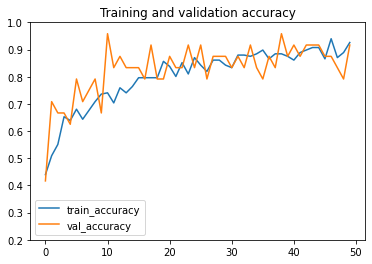

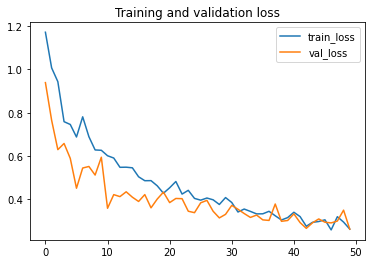

1/1 [==============================] - 0s 333ms/step - loss: 0.4219 - accuracy: 0.8750
{'loss': 0.42188549041748047, 'accuracy': 0.875}
Found 216 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.
Fold number 10
Epoch 1/50
7/7 [==============================] - 7s 516ms/step - loss: 1.2677 - accuracy: 0.3704 - val_loss: 0.7508 - val_accuracy: 0.5833

Epoch 00001: val_accuracy improved from -inf to 0.58333, saving model to C:/Users/user/Desktop/saved_models_2\model_10.h5
Epoch 2/50
7/7 [==============================] - 2s 320ms/step - loss: 1.0393 - accuracy: 0.4907 - val_loss: 0.7323 - val_accuracy: 0.6667

Epoch 00002: val_accuracy improved from 0.58333 to 0.66667, saving model to C:/Users/user/Desktop/saved_models_2\model_10.h5
Epoch 3/50
7/7 [==============================] - 2s 332ms/step - loss: 0.8773 - accuracy: 0.5787 - val_loss: 0.6279 - val_accuracy: 0.7500

Epoch 00003: val_accuracy improved from 0.66667 to 0.75000, 

7/7 [==============================] - 2s 310ms/step - loss: 0.3240 - accuracy: 0.8750 - val_loss: 0.2353 - val_accuracy: 0.9583

Epoch 00039: val_accuracy did not improve from 0.95833
Epoch 40/50
7/7 [==============================] - 2s 311ms/step - loss: 0.3175 - accuracy: 0.9213 - val_loss: 0.2899 - val_accuracy: 0.9583

Epoch 00040: val_accuracy did not improve from 0.95833
Epoch 41/50
7/7 [==============================] - 2s 319ms/step - loss: 0.3489 - accuracy: 0.8657 - val_loss: 0.2495 - val_accuracy: 0.9583

Epoch 00041: val_accuracy did not improve from 0.95833
Epoch 42/50
7/7 [==============================] - 2s 311ms/step - loss: 0.3078 - accuracy: 0.8981 - val_loss: 0.2686 - val_accuracy: 0.9583

Epoch 00042: val_accuracy did not improve from 0.95833
Epoch 43/50
7/7 [==============================] - 2s 311ms/step - loss: 0.3030 - accuracy: 0.9074 - val_loss: 0.3243 - val_accuracy: 0.9167

Epoch 00043: val_accuracy did not improve from 0.95833
Epoch 44/50
7/7 [==========

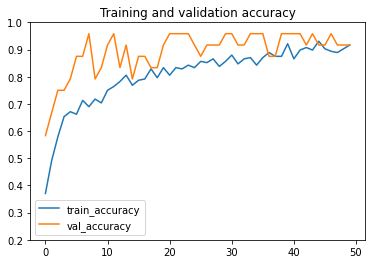

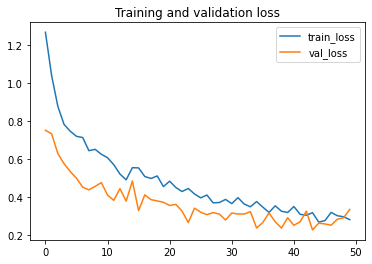

1/1 [==============================] - 0s 305ms/step - loss: 0.4174 - accuracy: 1.0000
{'loss': 0.4173649847507477, 'accuracy': 1.0}


In [24]:
#initialize parameters
VALIDATION_ACCURACY = []                          #store all validation_accuracy
VALIDATION_LOSS = []                              #store all validation_loss
image_dir = directory + "/ToBeUsed/train_set"     #where the train set images are stored
batch_size = 32                                   #batch size
fold_var = 1                                      #number of fold of the model
n = len(df2)                                      #number of data in train set
num_epochs = 50                                   #number of epochs
dim = (224,224)                                   #required dimensions for process_unit (ResNet50)
lr = 0.00001                                      #learning rate Adamax

#===========if exist, create new one for another set of models with new parameters======================

#directory where models per set parameters are stored
gen_dir = "C:/Users/user/Desktop"

save_cur = ""  #check if there is any saved_models folders

svnum = 0
svnum2 = 0

for x in os.listdir(gen_dir):
    if "saved_models" in x:
        #print(x)
        save_cur = x
        if not save_cur == "":
            for word in save_cur.split("_"):
                if word.isdigit():
                    svnum2 = int(word)
                    if svnum < svnum2:
                        svnum = svnum2
            #print(svnum)
            

#save_dir is where the created models using the current set of parameters are added        

if save_cur == "":
    save_dir = gen_dir + "/saved_models_1"
    #print(save_dir)
    os.makedirs(save_dir)
else:
    save_dir = gen_dir + "/saved_models_" + str(svnum + 1)
    #print(save_dir)
    os.makedirs(save_dir)

#=========================================================================================================    
    
for train_index, val_index in kf.split(np.zeros(n),Y):
    #print(train_index)
    #print(val_index)
    training_data = df2.iloc[train_index]
    
    #print(training_data)
    
    validation_data = df2.iloc[val_index]
    
    #print(validation_data)

    train_data_generator = imgdatagen.flow_from_dataframe(training_data, directory = image_dir,
                               x_col = "filename", y_col = "label",
                              class_mode = "categorical", target_size = dim, batch_size = batch_size,
                                shuffle = False)
    valid_data_generator  = imgdatagen.flow_from_dataframe(validation_data, directory = image_dir,
                            x_col = "filename", y_col = "label",
                            class_mode = "categorical", target_size = dim, batch_size = batch_size,
                                shuffle = False)

    # CREATE NEW MODEL
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in conv_model.layers:
        layer.trainable = False
    
    """
    #print(conv_model.output_shape)
    x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x) #to further reduce overfitting
    """
    x = keras.layers.Flatten()(conv_model.output)
    x = keras.layers.Dense(100, activation='relu')(x)
    x = keras.layers.Dense(100, activation='relu')(x)
    #x = keras.layers.Dense(100, activation='relu')(x)

    x = keras.layers.Dropout(0.2)(x) #to further reduce overfitting
    
    predictions = keras.layers.Dense(3, activation='softmax')(x)
    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
    
    #full_model.summary()
    
    # COMPILE NEW MODEL
    full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(learning_rate=lr),
                  metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "model_" + str(fold_var) + ".h5"), 
                            monitor='val_accuracy', verbose=1, 
                            save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
   
    print("Fold number " + str(fold_var))

    # FIT THE MODEL
    history = full_model.fit(train_data_generator,
                             epochs=num_epochs,
                             callbacks=callbacks_list,
                             validation_data=valid_data_generator)
    
    #PLOT HISTORY
    plot_history(history, yrange=(0.2,1))

    # LOAD BEST MODEL to evaluate the performance of the model
    full_model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")
    
    results = full_model.evaluate(valid_data_generator)
    results = dict(zip(full_model.metrics_names,results))
    
    print(results)
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1    

In [25]:
print("Validation Accuracy of All Folds:")
print(VALIDATION_ACCURACY)
print("Mean Validation Accuracy: " + str(np.mean(VALIDATION_ACCURACY)))
print("")
print("Validation Loss of All Folds:")
print(VALIDATION_LOSS)
print("Mean Validation Loss: " + str(np.mean(VALIDATION_LOSS)))

Validation Accuracy of All Folds:
[0.9166666865348816, 0.875, 0.7916666865348816, 0.75, 0.7916666865348816, 0.7916666865348816, 0.75, 0.75, 0.875, 1.0]
Mean Validation Accuracy: 0.8291666746139527

Validation Loss of All Folds:
[0.32685521245002747, 0.4580070972442627, 0.48557719588279724, 0.6675159931182861, 0.6324232816696167, 0.49221479892730713, 0.5675401091575623, 0.46809637546539307, 0.42188549041748047, 0.4173649847507477]
Mean Validation Loss: 0.4937480539083481


## Model Prediction

Recreate the structure of the model used and load the weights

In [26]:
resnet50 = keras.applications.resnet50

conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False

"""
#print(conv_model.output_shape)
x = keras.layers.GlobalAveragePooling2D()(conv_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x) #to further reduce overfitting
"""
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
#x = keras.layers.Dense(100, activation='relu')(x)

x = keras.layers.Dropout(0.2)(x) #to further reduce overfitting

predictions = keras.layers.Dense(3, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

model_dir = "C:/Users/user/Desktop/saved_models_2/model_1.h5"

full_model.load_weights(model_dir)

load images in the test set and predict what class it is by using the model. There are three values of accuracy. The one with the highest accuracy is the predicted class of the image.

In [28]:
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

for img_path in X_test['filename']:
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    print(x.shape)
    print(img_path)
    print(full_model.predict(x))
    #print(full_model.predict_classes(x))
    #plt.imshow(img)

(1, 224, 224, 3)
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\IMG_14561032_480555.jpg
[[0.91334957 0.04179543 0.04485495]]
(1, 224, 224, 3)
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\IMG_65813878_960629.jpg
[[0.75604194 0.2167187  0.02723941]]
(1, 224, 224, 3)
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\IMG_3320901_987553.jpg
[[0.09052057 0.5294539  0.38002557]]
(1, 224, 224, 3)
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\IMG_90116739_661402.jpg
[[0.02927274 0.3513339  0.61939335]]
(1, 224, 224, 3)
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\IMG_40672127_52189.jpg
[[0.20092228 0.21681811 0.5822596 ]]
(1, 224, 224, 3)
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\IMG_87310373_255859.jpg
[[0.35808358 0.2853652  0.35655126]]
(1, 224, 224, 3)
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\IMG_59278556_603169.jpg
[[0.10244577 0.13545194 0.7621023 ]]
(1, 224, 224, 3)
C:/Users/user/Desktop/Dataset/ToBeUsed/test_set\IMG_5885629_848766.jpg
[[0.9430801  0.05087691 0.006043

## Model Evaluation

Model Metrics such as precision will then be acquired from the predictions of the whole test set.

In [29]:
test_set = "C:/Users/user/Desktop/Dataset/ToBeUsed/test_set"

testX = []

for img_path in X_test['filename']:
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = x.reshape(224,224,3)
    testX.append(x)

testX = np.array(testX)    
    
#print(testX)
    
# predict probabilities for test set, y_test
yhat_probs = full_model.predict(testX, verbose=0)
print(yhat_probs)

# predict crisp classes for test set
yhat_classes = yhat_probs.argmax(axis=-1)
print(yhat_classes)

yh_classes = [[x] for x in yhat_classes]
print(type(yh_classes))
yh_classes = np.array(yh_classes)
print(type(yh_classes))
print(type(yh_classes[0]))
print(yh_classes)

[[0.91334975 0.04179526 0.04485501]
 [0.75604445 0.21671622 0.02723935]
 [0.09052033 0.52945155 0.38002813]
 [0.02927298 0.35133347 0.6193936 ]
 [0.20092222 0.21681888 0.5822589 ]
 [0.35808498 0.28536525 0.3565498 ]
 [0.10244749 0.13545235 0.7621001 ]
 [0.9430793  0.05087766 0.00604306]
 [0.01873031 0.18716109 0.7941086 ]
 [0.88457835 0.07449401 0.04092767]
 [0.760485   0.2031862  0.03632881]
 [0.0757217  0.5228632  0.4014151 ]
 [0.21039088 0.68528366 0.10432552]
 [0.13280708 0.41622278 0.45097008]
 [0.00698999 0.9502784  0.04273169]
 [0.02602163 0.891127   0.08285143]
 [0.34496784 0.3459373  0.30909488]
 [0.18723622 0.10133605 0.71142775]
 [0.94289374 0.05258055 0.00452573]
 [0.9348281  0.04825545 0.01691635]
 [0.04490589 0.79051393 0.16458018]
 [0.6523376  0.27764213 0.07002016]
 [0.78792846 0.14949897 0.06257252]
 [0.11532652 0.6771115  0.20756195]
 [0.0302204  0.8384332  0.13134639]
 [0.9178051  0.05781796 0.02437702]
 [0.9264989  0.05227087 0.02123034]
 [0.27337313 0.674392   0.05

In [30]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yh_classes = yh_classes[:, 0]

In [31]:
#for x in X_test['filename']:
#    print(x)

In [32]:
#print(y_test)
#print(y_test.dtypes)

#make the labels to integer to get the model metrics
y_test['label'] = pd.to_numeric(y_test['label'])

#print(y_test)
#print(y_test.dtypes)

C:\Users\user\AppData\Local\Temp/ipykernel_14088/3793398402.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['label'] = pd.to_numeric(y_test['label'])


In [33]:
yt = y_test.to_numpy()
yt = yt.reshape(len(y_test))
yt = np.array(yt)

print(yt)


print(yhat_classes)

print(yt.shape)
print(yhat_classes.shape)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average="weighted")
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
#print(y_test.shape)

#print(len(y_test))

recall = recall_score(y_test, yhat_classes, average="weighted")
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average="weighted")
print('F1 score: %f' % f1)

[0 0 2 2 2 0 1 0 2 0 0 2 2 1 1 2 0 2 0 0 1 0 0 1 1 0 0 1 1 1 0 1 2 0 2 1 2
 0 0 1 2 2 1 2 0 0 1 2 1 2 1 1 2 0 1 2 2 2 1 1]
[0 0 1 2 2 0 2 0 2 0 0 1 1 2 1 1 1 2 0 0 1 0 0 1 1 0 0 1 1 1 0 1 2 0 2 2 1
 0 0 1 2 2 1 2 0 0 1 1 1 2 1 1 2 0 1 2 0 2 2 1]
(60,)
(60,)
Accuracy: 0.800000
Precision: 0.803453
Recall: 0.800000
F1 score: 0.798963


In [35]:
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)

ValueError: multi_class must be in ('ovo', 'ovr')

In [34]:
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[19  1  0]
 [ 0 16  4]
 [ 1  6 13]]
